In [1]:
%load_ext lab_black

# Introduction

In the previous chapter, we have met performance measures like the RMSE or the deviance to measure how good our models are. Unfortunately, we cannot fully rely on these values due to overfitting: The more our models overfit, the less we can trust in their "insample" performance, i.e., the performance on the data used to calculate the models. Selecting models based on their insample performance is equally bad. Overfitting should not be rewarded!

In this chapter, we will meet ways to estimate the performance of a model in a fair way and use it to select the best model among alternatives. They are all based on data splitting techniques, where the models are evaluated on fresh data not used for model calculation. A fantastic reference for this chapter is [1]. Before introducing these techniques, we will meet a competitor of the linear model.

Remark on performance measures: While loss functions are used by the algorithm to *fit* the model, a performance measure or an *evaluation metric* is a function used to monitor performance and to select models. Ideally, it is consistent with the loss function of the specific algorithm (for instance RMSE as metric and squared error as loss), but sometimes one makes an exception.
For classification, besides monitoring average (multi-)log loss, e.g., one sometimes considers the *confusion matrix* and its derived measures like accuracy, precision, recall, F1-score etc. [Wikipedia](https://en.wikipedia.org/wiki/Confusion_matrix) summarizes these concepts. The confusion matrix tabulates the combinations of actual classes and predicted classes. Note that measures derived from the confusion matrix do not enjoy good statistical properties and focussing on them might lead to suboptimal models. They should thus not be used for making decisions but rather as additional, easy to understand information.

# Nearest-Neighbour

A very simple and intuitive alternative to the linear model is the k-nearest-neighbour approach, originally introduced by Evelyn Fix and J. L. Hodges in an unpublished technical report in 1951. It can be applied for both regression and classification and works without fitting anything. The prediction for an observation is obtained by 

1. searching the closest k neighbours in the data set and then 
2. combining their responses. 

By "nearest" we usually mean Euclidean distance in the covariate space. If covariates are not on the same scale, it makes sense to *standardize* them first by subtracting the mean and dividing by the standard deviation. Otherwise, distances would be dominated by the covariate on the largest scale. Categorical features need to be one-hot- or integer-encoded first. Note that one-hot-encoded covariates may or may not be standardized.

For regression tasks, the responses of the k nearest neighbours are often combined by computing their arithmetic mean. For classification tasks, they are condensed by their most frequent value or to class probabilities.

## Example: nearest-neighbour

What prediction would we get with 5-nearest-neighbour regression for the 10'000th row of the diamonds data set?

In [2]:
from plotnine.data import diamonds
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

ord_vars = ["color", "cut", "clarity"]
ord_levels = [diamonds[x].cat.categories.to_list() for x in ord_vars]

# Prepare scaled feature matrix X
preprocessor = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("linear", "passthrough", ["carat"]),
            ("ordered", OrdinalEncoder(categories=ord_levels), ord_vars),
        ],
    ),
    StandardScaler(),
)
X = preprocessor.fit_transform(diamonds)
X[0:5]

array([[-1.19816781, -0.93716275,  0.98147332, -1.24521508],
       [-1.24036129, -0.93716275,  0.08588908, -0.63809506],
       [-1.19816781, -0.93716275, -1.70527938,  0.57614496],
       [-1.07158736,  1.41427211,  0.08588908, -0.03097505],
       [-1.02939387,  2.00213083, -1.70527938, -1.24521508]])

In [3]:
# Fit 5-NN model
model = KNeighborsRegressor(5).fit(X, diamonds["price"])

# Apply it to the 10'000th observation
ix = 9999
print(f"Prediction of 10'000th obs: {model.predict(X[[ix]])}")
print("The observation:")
diamonds.iloc[[ix]]

Prediction of 10'000th obs: [4907.8]
The observation:


,carat,cut,color,clarity,depth,table,price,x,y,z
9999,1.0,Fair,D,SI1,64.9,59.0,4704,6.2,6.13,4.0


In [4]:
# Its five nearest neighbours
nearest_5_finder = NearestNeighbors(n_neighbors=5).fit(X)
dist, nearest_5 = nearest_5_finder.kneighbors(X[[ix]])
diamonds.iloc[nearest_5.flatten()]

,carat,cut,color,clarity,depth,table,price,x,y,z
10000,1.0,Fair,D,SI1,65.9,54.0,4704,6.24,6.20,4.10
12786,1.0,Fair,D,SI1,65.5,60.0,5331,6.18,6.12,4.03
11827,1.0,Fair,D,SI1,67.3,57.0,5096,6.15,6.04,4.10
9980,1.0,Fair,D,SI1,66.3,58.0,4704,6.15,6.04,4.04
9999,1.0,Fair,D,SI1,64.9,59.0,4704,6.20,6.13,4.00


**Comments** 

- The five nearest diamonds are extremely similar. One of them is the observation of interest itself, introducing a relevant amount of overfitting.
- The average price of these five observations gives us the nearest-neighbour prediction for the 10'000th diamond.
- Would we get better results for a different choice of the number of neighbours k?
- Three lines are identical up to the perspective variables (`depth`, `table`, `x`, `y`, `z`). These rows most certainly represent the same diamond, introducing additional overfit. We need to keep this problematic aspect of the diamonds data in mind.

**Motivation for this chapter:** Insample, a 1-nearest-neighbour regression predicts without error, a consequence of massive overfitting. This hypothetical example indicates that insample performance is often not worth a penny. Models need to be evaluated on fresh, independent data not used for model calculation. This leads us to *simple validation*.

# Simple Validation

With simple validation, the original data set is partitioned into *training* data used to calculate the models and a separate *validation* data set used to evaluate model performance and/or to select models. Typically, 10%-30% of rows are used for validation.

We can use the validation performance to compare *algorithms* (regression versus k-nearest-neighbour etc.) and also to choose their *hyperparameters* like the "k" of k-nearest-neighbour.

Furthermore, the performance difference between training and validation data gives an impression of the amount of overfitting (or rather of the *optimism*).

## Example: simple validation

We now use a 80%/20% split on the diamonds data to calculate RMSE of 5-nearest-neighbour on both training and validation data. What k provides the best validation RMSE?

In [5]:
import pandas as pd
from plotnine.data import diamonds
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

# Split data into train and valid
df_train, df_valid, y_train, y_valid = train_test_split(
    diamonds, diamonds["price"], test_size=0.2, random_state=49
)
print("Training data size:", df_train.shape)
print("Validation data size:", df_valid.shape)

Training data size: (43152, 10)
Validation data size: (10788, 10)


In [6]:
# Define preprocessing pipeline
ord_vars = ["color", "cut", "clarity"]
ord_levels = [diamonds[x].cat.categories.to_list() for x in ord_vars]

preprocessor = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("linear", "passthrough", ["carat"]),
            ("ordered", OrdinalEncoder(categories=ord_levels), ord_vars),
        ],
    ),
    StandardScaler(),
)

# Fit preprocessor on df_train and apply it to df_valid
X_train = preprocessor.fit_transform(df_train)
X_valid = preprocessor.transform(df_valid)
X_valid[0:5]

array([[-0.18579638, -0.3537962 , -0.81057684,  1.78590102],
       [ 1.48042665,  0.82162926, -1.70662183, -0.64005046],
       [-0.01706494,  1.40934199, -0.81057684, -0.64005046],
       [ 0.86877516, -0.3537962 , -0.81057684,  1.17941315],
       [ 1.56479237,  1.99705472, -0.81057684, -0.64005046]])

In [7]:
# Performance of 5-nearest-neighbour regression
mod = KNeighborsRegressor(5).fit(X_train, y_train)
rmse_train = mse(y_train, mod.predict(X_train), squared=False)
rmse_valid = mse(y_valid, mod.predict(X_valid), squared=False)
print(f"Training RMSE: {rmse_train: .1f}")
print(f"Validation RMSE: {rmse_valid: .1f}")

Training RMSE:  514.7
Validation RMSE:  612.4


**Comment:** Validation RMSE is substantially worse than training RMSE, a clear sign of overfitting. However, it is still much better than the (full-sample) performance of linear regression (see Exercise 1, Chapter 1).

Can we find a k with better validation RMSE?

In [8]:
# Loop over k and store train and valid rmse
data_pairs = ((y_train, X_train), (y_valid, X_valid))
search = {}
for k in range(1, 21):
    mod = KNeighborsRegressor(k).fit(X_train, y_train)
    search[k] = [mse(y, mod.predict(X), squared=False) for y, X in data_pairs]
    print(k, ":", search[k])

1 : [517.4695404529873, 746.3375194857978]
2 : [471.11902126881745, 643.207662481919]
3 : [482.2736853087685, 623.6324306602825]
4 : [496.6449599826686, 612.5977201460005]
5 : [514.6888705506161, 612.3874182853175]
6 : [526.7089256701005, 617.9574765985672]
7 : [539.1882807888525, 625.306023340122]
8 : [549.834650977257, 628.6275439083505]
9 : [555.7360033410931, 633.6258325111555]
10 : [564.380364900913, 643.5003214620236]
11 : [571.9069855279979, 643.2959011148638]
12 : [577.4660373506704, 645.6363154342883]
13 : [584.4450218836126, 649.0590360230304]
14 : [591.0082274814716, 650.0499144802976]
15 : [595.7818713464565, 652.5879098525286]
16 : [601.1084751906751, 654.3453567623119]
17 : [606.6123817248093, 657.5229805450292]
18 : [611.4334274943302, 661.4355349179331]
19 : [616.7807609546247, 662.7973339248962]
20 : [620.9544730263045, 665.0574777370142]


,Train,Valid
1,517.469540,746.337519
2,471.119021,643.207662
3,482.273685,623.632431
4,496.644960,612.597720
5,514.688871,612.387418
6,526.708926,617.957477
7,539.188281,625.306023


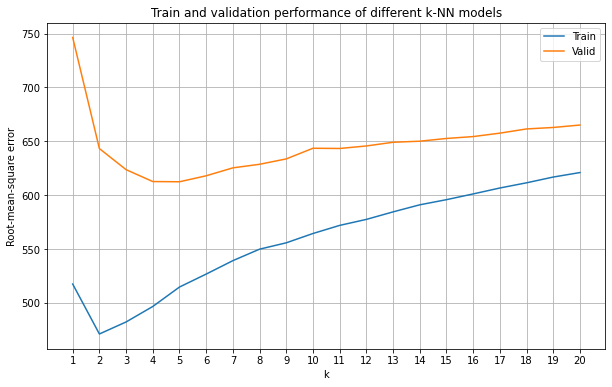

In [9]:
# Organize and plot results
results = pd.DataFrame.from_dict(search, orient="index", columns=["Train", "Valid"])
results.plot(
    figsize=(10, 6),
    grid=True,
    xticks=results.index,
    xlabel="k",
    ylabel="Root-mean-square error",
    title="Train and validation performance of different k-NN models",
)
results.head(7)

**Comments**

- The amount of overfitting decreases for growing k, which makes sense.
- Selecting k based on the training data would lead to a suboptimal model.
- Based on the validation data, we would choose $k=5$. It has a minimal RMSE of 612 USD.
- Why is the RMSE on the training data not 0 for 1-nearest-neighbour?
- Why is it problematic that some diamonds appear multiple times in the dataset?

# Cross-Validation (CV)

If our data set is large and training takes long, then the simple validation strategy introduced above is usually good enough. For smaller data or if training is fast, there is a better alternative that uses the data in a more economic way and takes more robust decisions. It is called **k-fold cross-validation** and works as follows:

1. Split the data into k pieces $D = \{D_1, \dots, D_k\}$ called "folds". Typical values for k are five or ten.
2. Set aside one of the pieces ($D_j$) for validation.
3. Fit the model on all other pieces, i.e., on $D \setminus D_j$.
4. Calculate the model performance on the validation data $D_j$.
5. Repeat Steps 2-4 until each piece was used for validation once.
6. The average of the k model performances yields the *CV performance* of the model.

The CV performance is a good basis to choose the best and final model among alternatives. The final model is retrained on all folds.

**Notes**
- The "best" model is typically the one with best CV performance. Depending on the situation, it could also be a model with "good CV performance and not too heavy overfit compared to insample performance" or some other reasonable criterion.
- If cross-validation is fast, you can repeat the process for additional data splits. Such *repeated* cross-validation leads to even more robust results.


## Example: cross-validation

We now use five-fold CV on the diamonds data to find the optimal k, i.e., to *tune* our nearest-neighbour approach.

In [10]:
# First part
import pandas as pd
from plotnine.data import diamonds
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold

ord_vars = ["color", "cut", "clarity"]
ord_levels = [diamonds[x].cat.categories.to_list() for x in ord_vars]

# Define encoder
encoder = ColumnTransformer(
    transformers=[
        ("linear", "passthrough", ["carat"]),
        ("ordered", OrdinalEncoder(categories=ord_levels), ord_vars),
    ],
)

# Full model pipeline (with arbitrary n_neighbors)
knn_model = Pipeline(
    steps=[
        ("encoder", encoder),
        ("scaler", StandardScaler()),
        ("knn", KNeighborsRegressor(n_neighbors=5)),
    ]
)

,rmse
1,840.923292
2,724.343695
3,676.485357
4,654.138927
5,643.752960
6,637.520350
7,634.841915
8,635.138787
9,636.395363
10,637.184963


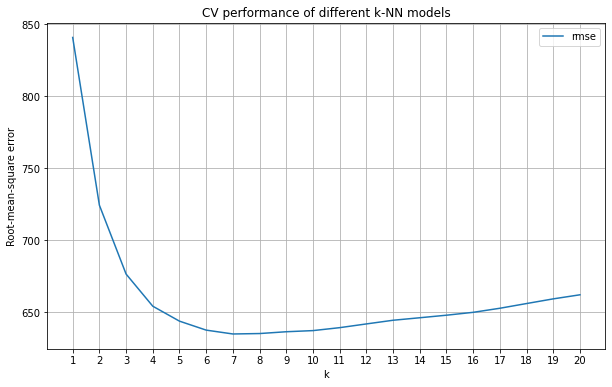

In [11]:
# Second part (A): 5-fold cross-validation for different values of n_neighbors
cv = KFold(n_splits=5, shuffle=True, random_state=4302)
search = {}
for k in range(1, 21):
    knn_model.set_params(knn__n_neighbors=k)
    search[k] = -cross_val_score(
        knn_model,
        X=diamonds,
        y=diamonds["price"],
        scoring="neg_root_mean_squared_error",
        cv=cv,
    ).mean()
# Alternative to initializing KFold: shuffle(!) diamonds and then use cv=5.
# Reason: diamonds are sorted by carat. Using fixed folds would be very bad.

# Organize and plot results
results = pd.DataFrame.from_dict(search, orient="index", columns=["rmse"])
results.plot(
    figsize=(10, 6),
    grid=True,
    xticks=results.index,
    xlabel="k",
    ylabel="Root-mean-square error",
    title="CV performance of different k-NN models",
)
results.head(10)

**Comment:** Using 7 neighbours seems to be the best choice with a CV RMSE of 635 USD. Again, the fact that certain diamonds appear multiple times leaves a slightly bad feeling. Should we really trust these results?

Scikit-learn offers such "grid searches" (see next paragraph below) out-of-the box. For above example, it would simplify the second part of the code:

In [12]:
# Second part (B): 5-fold cross-validation for different values of n_neighbors
from sklearn.model_selection import GridSearchCV

# Define "tuning grid"
param_grid = {"knn__n_neighbors": range(1, 21)}

# Initialize and fit GridSearch to find best k with 5-fold cross-validation
search = GridSearchCV(
    knn_model,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=KFold(n_splits=5, shuffle=True, random_state=4302),
)
search.fit(X=diamonds, y=diamonds["price"])
# Note: the best model is being refitted on full training data -> convenient!

# Organize results
results = pd.DataFrame(
    -search.cv_results_["mean_test_score"],
    index=param_grid["knn__n_neighbors"],
    columns=["rmse"],
)
results.head(10)

# Note: This combination of a pipeline and grid search would even allow to
# tune parametrized steps in the preprocessing (not relevant in this example).

,rmse
1,840.923292
2,724.343695
3,676.485357
4,654.138927
5,643.752960
6,637.520350
7,634.841915
8,635.138787
9,636.395363
10,637.184963


# Grid Search

In the above example, we have systematically compared the CV-performance of k-nearest-neighbour by iterating over a grid of possible values for k. Such strategy to *tune* models, i.e., to select hyperparameters of a model is called **grid search CV**. In the next chapter, we will meet situations where multiple parameters have to be optimized simultaneously. Then, the number of parameter combinations and the grid size explode. To save time, we could evaluate only a random subset of parameter combinations, an approach called **randomized search CV**.

# Test Data and Final Workflow

Often, modeling involves many decisions. Even if guided by (cross-)validation, each decision tends to make the resulting final model look better than it is, an effect that can be called *overfitting on the validation data*. As a consequence, we often do not know how well the final model will perform in reality. As a solution, we can set aside a small *test* data set used to assess the performance of the *final* model. A size of 5%-20% is usually sufficient. 
It is important to look at the test data just once at the very end of the modeling process - after each decision has been made.

Note: Such additional test data set is only necessary if one uses the validation data set to *make decisions*. If the validation data set is just used to assess the true performance of a model, then we do not need this extra data set. Then, we can use the terms "validation data" and "test data" interchangeably.

Depending on whether one does simple validation or cross-validation, the typical workflow is as follows:

**Workflow A**

1. Split data into train/valid/test, e.g., by ratios 70%/20%/10%.
2. Train different models on the training data and assess their performance on the validation data. Choose the best model, retrain it on the combination of training and validation data and call it "final model".
3. Assess the performance of the final model on the test data.

**Workflow B**

1. Split data into train/test, e.g., by ratios 90%/10%.
2. Evaluate and tune different models by k-fold cross-validation on the training data. Choose the best model, retrain it on the full training data.
3. Assess performance of the final model on the test data.

The only difference across the two workflows is whether to use simple validation or cross-validation for making decisions.

## Example: test data

We will now go through Workflow B for our diamond price model. We will (1) tune the "k" of our nearest-neighbour regression and (2) compete with a linear regression.

In [13]:
import numpy as np
from plotnine.data import diamonds
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    FunctionTransformer,
)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
    GridSearchCV,
)

ord_vars = ["color", "cut", "clarity"]
lvl = [diamonds[x].cat.categories.to_list() for x in ord_vars]

# Split data into train and test
df_train, df_test, y_train, y_test = train_test_split(
    diamonds, diamonds["price"], test_size=0.1, random_state=49
)

# Define CV strategy
cv = KFold(n_splits=5, shuffle=True, random_state=4432)

# Cross-validation performance of linear regression
linear_regression = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("log", FunctionTransformer(np.log), ["carat"]),
            ("dummies", OneHotEncoder(categories=lvl, drop="first"), ord_vars),
        ]
    ),
    LinearRegression(),
)

results_linear = -cross_val_score(
    linear_regression,
    X=df_train,
    y=y_train,
    scoring="neg_root_mean_squared_error",
    cv=cv,
)
print(f"Linear regression CV RMSE: {results_linear.mean():.3f}")

Linear regression CV RMSE: 1849.868


In [14]:
# Cross-validation performance of k-nearest-neighbour for k = 1-20
knn_encoder = ColumnTransformer(
    transformers=[
        ("linear", "passthrough", ["carat"]),
        ("ordered", OrdinalEncoder(categories=lvl), ord_vars),
    ],
)
knn_regression = Pipeline(
    steps=[
        ("encoder", knn_encoder),
        ("scaler", StandardScaler()),
        ("knn", KNeighborsRegressor(n_neighbors=5)),
    ]
)

search = GridSearchCV(
    knn_regression,
    param_grid={"knn__n_neighbors": range(1, 21)},
    scoring="neg_root_mean_squared_error",
    cv=KFold(n_splits=5, shuffle=True, random_state=4302),
)
# Remember: the best model is refitted on training data
search.fit(X=df_train, y=y_train)
print(f"Best k of k-NN: {search.best_params_}")
print(f"Its CV-RMSE: {-search.best_score_:.3f}")
print("Best model seems 4-NN!")

Best k of k-NN: {'knn__n_neighbors': 4}
Its CV-RMSE: 629.805
Best model seems 4-NN!


In [15]:
# The overall best model is 4-nearest-neighbour
final_rmse = mse(y_test, search.predict(df_test), squared=False)
print(f"Test RMSE of final model: {final_rmse:.3f}")

Test RMSE of final model: 576.327


**Comments** 

- 4-nearest-neighbour regression performs much better than linear regression.
- Its performance on the independent test data is even better than CV suggests. Could this be a consequence of the fact that certain diamonds appear multiple times in the data, introducing potential "leakage" from training to test data?

# Random Splitting?

The data is often *randomly split* into partitions or folds. As long as rows are *independent*, this leads to honest estimates of model performance as it ensures independent data partitions. 

When rows are not independent, e.g., with time series data or grouped data, such strategy is flawed and leads to too optimistic results. **This is one of the most frequent reasons to end up with a bad model. It is essential to avoid it.**

## Time-series data

When data represents a time series, splitting is best done in a way that does not destroy the temporal order. For simple validation, e.g., the first 80% of rows could be used for training and the remaining 20% for validation. 

## Grouped data

Often, data is grouped or clustered by some (hopefully known) ID variable, e.g.,

- multiple rows belong to the same patient/customer or
- duplicated rows (accidental or not). 

Then, instead of distributing *rows* into partitions, we should distribute *groups*/IDs in order to not destroy the data structure and to get honest performance estimates. We speak of *grouped splitting* and *group k-fold CV*. 

In our example with diamonds data, it would be useful to have a column with diamond "id" that could be used for grouped splitting. (How would you create a proxy for this?)

## Stratification

*If rows are independent*, there is a variant of random splitting that often provides better results and is therefore frequently used: *stratified splitting*. With stratified splitting or *stratified k-fold CV*, rows are split to ensure approximately equal distribution of a key variable (the response or deciding covariate) across partitions/folds.

# Exercises

1. Regarding the problem that some diamonds seem to appear multiple times in the data: As an alternative to *grouped* splitting, repeat the last example also on data deduplicated by `price` and all covariates. Do the results change? Which results do you trust more?
2. Use cross-validation to select the best polynomial degree to represent `log(carat)` in the Gamma GLM with log-link (with additional covariates `color`, `cut`, and `clarity`). Evaluate the result on an independent test data.
3. Optional: Compare the linear regression for `price` (using `log(carat)`, `color`, `cut`, and `clarity` as covariates) with a corresponding Gamma GLM with log-link by simple validation. Use once (R)MSE for comparison and once Gamma deviance. What do you observe?

# Chapter Summary

In this chapter, we have met strategies to estimate model performance in a fair way. These strategies are also used for model selection and tuning. They are an essential part of the full modeling process. ML models without appropriate validation strategy are not to be trusted. 

# Chapter References

[1] T. Hastie, R., Tibshirani, and J. Friedman. The Elements of Statistical Learning: Data Mining, Inference, and Prediction. New York: Springer, 2001.